In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt

In [2]:
#filename = 't005_alpha_func_phi.npy'
filename = 'v03_alpha_func_phi.npy'
#filename = 'r03_alpha_func_phi.npy'
#filename = 'v005_alpha_func_phi.npy'

raw = np.load(filename)
def Amp_Delta_grid():
    Amp, Delta  = raw[:,1,:],raw[:,0,:]
    alpha  = 0.01*np.arange(10,45)
    phi    = np.linspace(0,1,100,endpoint=False)*2*np.pi
    iAmp   = si.RectBivariateSpline(alpha,phi,Amp)
    iDelta = si.RectBivariateSpline(alpha,phi,Delta)
    return iAmp, iDelta

In [3]:
iAmp,iDelta = Amp_Delta_grid()
def waveform(phi , t , alpha , const_phase, phi0 = 0., tobs = 0.25):
    # t, t0, tobs [s]
    cphi = np.remainder(phi + phi0 , 2*np.pi)
    sort = np.argsort(cphi) # sort the cphi
    rsort = np.argsort(sort) # sort the sort ... to reverse the sort
    Amp = iAmp(alpha,cphi[sort])[0][rsort]
    Delta = iDelta(alpha,cphi[sort])[0][rsort]
    
    freq = alpha/(201160./86400)
    wash_out = np.sin(2*np.pi*freq*tobs/2.)/(2*np.pi*freq*tobs/2.)
    waveform = - wash_out*Amp[None,:]*np.cos(2*np.pi*t[:,None]*freq + cphi[None,:] + Delta[None,:] + const_phase)
    
    return waveform


def gen_calc_norm_chisq(varphi5,sig5,varphi11,sig11):
    
    def calc_norm_chisq(alpha,phi0):
        evpa1 = waveform(varphi5 , np.array([6,5]) , alpha , phi0)*57.3
        evpa2 = waveform(varphi11 , np.array([11,10]) , alpha , phi0)*57.3

        devpa1 = np.diff(evpa1,axis=0)
        devpa2 = np.diff(evpa2,axis=0)

        chisq1 = np.sum(devpa1**2/sig5**2)
        chisq2 = np.sum(devpa2**2/sig11**2)
        chisq_norm = chisq1 + chisq2

        return chisq_norm
    
    return np.vectorize(calc_norm_chisq)


def ipgen(lnlike_xy):
    
    z_list = np.linspace(0,lnlike_xy.max(),200)
    lnlike_msk = (lnlike_xy[:,:,None]<=z_list[None,None,:])*lnlike_xy[:,:,None]
    int_prob_list = lnlike_msk.sum(axis=0).sum(axis=0)
    
    ip = lambda int_prob:np.interp(int_prob*int_prob_list.max(),int_prob_list,z_list)
    return ip
    
def quantile95(lnlike_xy ,ylist ):
    
    xlist = np.arange(100)
    ylist = ylist
    int_prob_list = np.cumsum(lnlike_xy,axis=1)
    maxvals = np.max(int_prob_list,axis=1)
    int_prob_list2 = int_prob_list/maxvals[:,None]
    uls = []
    for i in range(len(xlist)):
        ul = np.interp(0.95,int_prob_list2[i,:] ,ylist)
        uls.append(ul)
    
    
    return np.array(uls)

In [4]:
phi = np.linspace(0,2*np.pi,200,endpoint=False)
t = np.array([5.,6.,10.,11.])
#t = np.array([5.,11.])

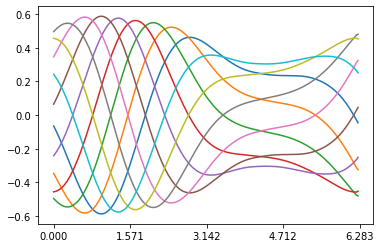

In [5]:
for i in np.arange(10):
    out = waveform( phi , t , 0.4 , i/10*2*np.pi )
    plt.plot(phi,out[3])
#colors = ['r','r--','k','k--']
plt.xticks([0,np.pi/2,np.pi,np.pi*3/2,2*np.pi]);

#plt.plot(phi,out[3]-out[2],'k--')

# Data

In [6]:
alphas = np.linspace(0.1,0.45,100)
phis = np.linspace(0,1,80,endpoint=False)*2*np.pi
alpha_mesh,phi_mesh = np.meshgrid(alphas,phis,indexing='ij')
c = np.logspace(np.log10(1/137),3,90)
#ga = np.logspace(-3,3,90)/2/np.pi
ga = c/2/np.pi
def calculate_ul95_with_data(source):

    data5 = np.loadtxt('all_data/'+source+'/'+source+'_sigma_5th.csv',delimiter=',').T
    data11 = np.loadtxt('all_data/'+source+'/'+source+'_sigma_11th.csv',delimiter=',').T
    varphi5,sig5 = data5[0],data5[3]
    varphi11,sig11 = data11[0],data11[3]

    #data5 = np.loadtxt('DMC_sigma_5th.csv',delimiter=',').T
    #data11 = np.loadtxt('DMC_sigma_11th.csv',delimiter=',').T
    #varphi5,sig5 = data5[0],np.abs(data5[3])
    #varphi11,sig11 = data11[0],np.abs(data11[3])

    varphi5 = (varphi5-18.)/360*2*np.pi
    varphi11 = (varphi11-18.)/360*2*np.pi
    sig5 = sig5*np.sqrt(2)
    sig11 = sig11*np.sqrt(2)
    
    
    #ga = np.linspace(1e-20,1,200)/2/np.pi


    
    
    # Calculating Chisq
    calc_norm_chisq = gen_calc_norm_chisq(varphi5,sig5,varphi11,sig11)
    norm_chisq = calc_norm_chisq(alpha_mesh,phi_mesh)
    
    chisq = norm_chisq[:,:,None]*ga**2
    
    lnlike = np.exp(-chisq/2)
    _lnlike_xy = lnlike.mean(axis=1)
    lnlike_xy = _lnlike_xy
    
    ul95 = 10**quantile95(lnlike_xy,ylist = np.log10(ga))*2*np.pi
    
    return ul95

# Contour

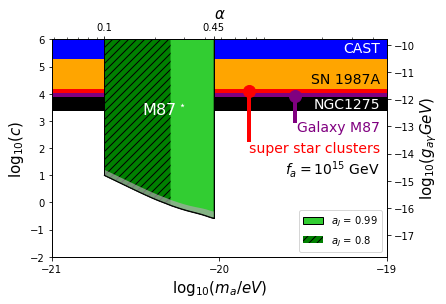

In [12]:
try:
    uldict
except:
    uldict={}
    

for source in ['polsolve','DMC','eht-imaging','LPCAL','Themis']:
#for source in ['polsolve','DMC']:
    amass = alphas*2.05591e-20
    _x,_y = np.meshgrid(np.log10(amass),np.log10(ga*2*np.pi),indexing='ij')
    ul95 = calculate_ul95_with_data(source)
    uldict.update({source:ul95})

fig,ax = plt.subplots(figsize=(6,4))
#plt.contourf(_x,_y,lnlike_xy,cmap='Greens_r',alpha=0.5,levels=[0,0.2,0.4,0.6,0.8,1],linestyles='--')
#clb = plt.colorbar()
#clb.set_label('$P/P_{max}$',size=15)


#plt.xlabel(r'$\alpha$',size=15)
plt.xlabel('$\log_{10}(m_a/eV)$',size=15)


plt.ylabel(r'$\log_{10}(c)$',size=15)
#plt.legend(handles = ctr.legend_elements()[0],labels=['95% upper limit'],loc=3)

#plt.yscale('log')
#plt.xscale('log')




    #Other Limits
plt.fill_between([-22,-14],[np.log10(8e-13/2*1e15*2*np.pi)]*2,[8,8],ls='-',lw=2,fc='black',alpha=1,ec='black')
plt.fill_between([-22,-14],[np.log10(2.6e-12/2*1e15*2*np.pi)]*2,[8,8],ls='-',lw=2,fc='purple',alpha=1,ec='purple')
plt.fill_between([-22,-14],[np.log10(3.6e-12/2*1e15*2*np.pi)]*2,[8,8],ls='-',lw=2,fc='red',alpha=1,ec='red')
plt.fill_between([-22,-14],[np.log10(5.3e-12/2*1e15*2*np.pi)]*2,[8,8],ls='-',lw=2,fc='orange',alpha=1,ec='orange')
plt.fill_between([-22,-14],[np.log10(6.6e-11/2*1e15*2*np.pi)]*2,[8,8],ls='-',lw=2,fc='blue',alpha=1,ec='blue')

plt.annotate('CAST',xy=(0.98,0.94),xycoords='axes fraction',color='white',ha='right',size=14)
plt.annotate('SN 1987A',xy=(0.98,0.8),xycoords='axes fraction',color='black',ha='right',size=14)
plt.annotate('NGC1275',xy=(0.98,0.685),xycoords='axes fraction',color='white',ha='right',size=14)

plt.annotate('super star clusters',xy=(0.98,0.48),xycoords='axes fraction',color='red',ha='right',size=14)
plt.plot([-19.82,-19.82],[2.3,4.1],lw=4,color='red')
plt.plot([-19.82],[4.1],lw=4,color='red',marker='o',markersize=12)

plt.annotate('Galaxy M87',xy=(0.98,0.58),xycoords='axes fraction',color='purple',ha='right',size=14)
plt.plot([-19.55,-19.55],[3,3.9],lw=4,color='purple')
plt.plot([-19.55],[3.9],lw=4,color='purple',marker='o',markersize=12)


#the UL
#divede into two parts
midindex = np.argmax(amass>=0.25*2.05591e-20)

ul95 = uldict['polsolve']
plt.fill_between(np.log10(amass[:]),np.log10(ul95[:]),8,ls='-',lw=1,ec='k',fc='limegreen',alpha=1,label='$a_J$ = 0.99')
plt.fill_between(np.log10(amass[:midindex]),np.log10(ul95[:midindex]),8,ls='-',lw=0,ec='k',fc='green',hatch='///',alpha=1,label='$a_J$ = 0.8')
#plt.plot(np.log10([amass[midindex],amass[midindex]]),[np.log10(ul95[midindex]),6],color='k',ls='-' )
#plt.plot(np.log10([amass[-1],amass[-1]]),[np.log10(ul95[-1]),6],color='k',ls='--' )

'''
Make the border clearer!!!
'''
plt.plot([np.log10(amass[0])]*2,[np.log10(ul95[0]),6],'k',lw=1)
plt.plot([np.log10(amass[-1])]*2,[np.log10(ul95[-1]),6],'k',lw=1)
plt.plot(np.log10(amass[:]),np.log10(ul95[:]),'k',ls='-',lw=1)


#for sname in uldict:
#    ul95 = uldict[sname]
#    plt.plot(np.log10(amass[:]),np.log10(ul95[:]),color='k')

plt.fill_between(np.log10(amass[:]),np.log10(uldict['polsolve']),np.log10(uldict['DMC']),fc ='darkgray',alpha=0.7) 


plt.annotate(r'M87$^\star$',xy=(0.27,0.65),xycoords='axes fraction',color='white',ha='left',size=16)

#plt.plot(np.log10(amass),np.log10(ga[z1]*2*np.pi),'r',label='$1\sigma$')
#plt.plot(np.log10(amass),np.log10(ga[z2]*2*np.pi),'orange',label='$2\sigma$')

logcmin = -2
logcmax = 6
fa = 1e15
loggmin = logcmin - np.log10(2*np.pi*fa)
loggmax = logcmax - np.log10(2*np.pi*fa)

plt.legend(loc=4)
plt.xlim(-21,-19)
plt.ylim(logcmin,logcmax)
plt.xticks([-21,-20,-19])


#fa
plt.annotate('$f_a=10^{15}$ GeV',xy=(0.98,0.38),xycoords='axes fraction',ha='right',size=14)





#alpha
ax2 = ax.twiny()



ax2.set_xlim(1e-21/2.05591e-20    ,   1e-19/2.05591e-20)
ax2.set_xscale('log')
ax2.set_xticks([0.1,0.45]);
ax2.set_xticklabels([0.1,0.45]);
ax2.set_xlabel(r'$\alpha$',size=15)
#plt.title(source)

ax3 = ax.twinx()
ax3.set_ylim(loggmin,loggmax)


ax3.set_ylabel(r'$\log_{10}(g_{a\gamma} GeV)$',size=15)


plt.savefig('ul.pdf',bbox_inches='tight')


In [13]:
uldictr03 = uldict.copy()

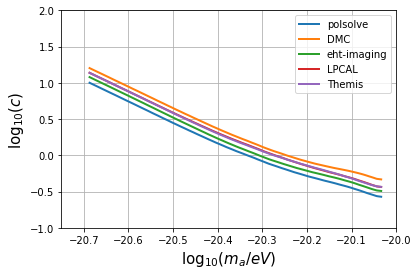

In [25]:

for p in uldict:
    #plt.plot(np.log10(amass[:]),np.log10(uldictv03[p]),label=p,lw=3)
    plt.plot(np.log10(amass[:]),np.log10(uldictr03[p]),ls='-',label=p,lw=2)
plt.legend()
plt.xlim(-20.75,-20)
plt.ylim(-1,2)
plt.grid()
plt.xlabel('$\log_{10}(m_a/eV)$',size=15)
plt.ylabel(r'$\log_{10}(c)$',size=15)

plt.savefig('comparison.pdf')